In [1]:
!pip install -q kagglehub pytorch_lightning torch

## Load dataset from Kaggle

In [7]:
from torchvision import transforms as T
from kagglehub import dataset_download

path = dataset_download("shubham1921/real-to-ghibli-image-dataset-5k-paired-images")
print("Path to dataset files:", path)

domain_a = f"{path}/dataset/trainA"
domain_b = f"{path}/dataset/trainB_ghibli"

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/shubham1921/real-to-ghibli-image-dataset-5k-paired-images/versions/1


## Convert the data into Lightning Modules

In [11]:
from data.dataset import UnpairedImageDataset
from data.datamodule import UnpairedDataModule

datamodule = UnpairedDataModule(
    domain_a_dir=domain_a,
    domain_b_dir=domain_b,
    batch_size=8,
    num_workers=4
)

datamodule.setup()

In [12]:
batch = next(iter(datamodule.train_dataloader()))
print("Domain A batch shape:", batch["a"].shape)
print("Domain B batch shape:", batch["b"].shape)

Domain A batch shape: torch.Size([8, 3, 256, 256])
Domain B batch shape: torch.Size([8, 3, 256, 256])


### Check resized image

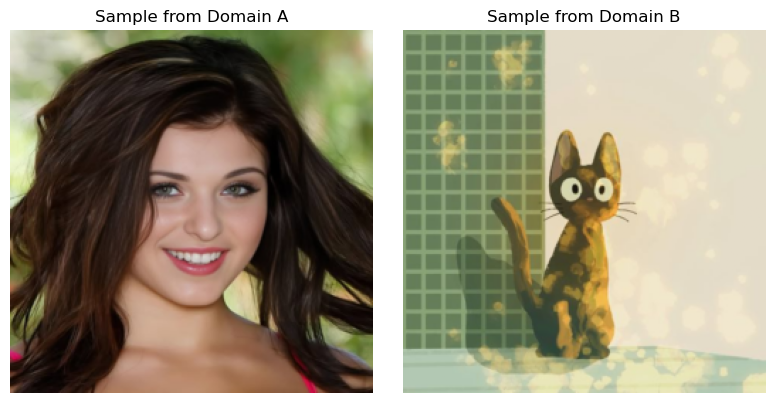

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):
    return tensor * 0.5 + 0.5 

a_tensor = batch["a"][0]
b_tensor = batch["b"][0]

a_img = denormalize(a_tensor).permute(1, 2, 0).numpy()
b_img = denormalize(b_tensor).permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(a_img)
axs[0].set_title("Sample from Domain A")
axs[0].axis("off")

axs[1].imshow(b_img)
axs[1].set_title("Sample from Domain B")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# Training

In [ ]:
import cycleGAN

## Example Training

In [ ]:
training = cycleGAN.Training("sample-training", cycleGAN.TrainableCycleGAN(cycleGAN.CycleGANConfig(), cycleGAN.TrainConfig()), datamodule)

In [ ]:
training()

## Example Sweep

In [ ]:
from cycleGAN.training_defaults import  ENTITY_NAME, PROJECT_NAME

In [ ]:
sweep_config = {
    "name": "sample-sweep",
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "max_epochs": {"value": 200},
        "start_epoch": {"value": 0},
        "decay_epoch": {"value": 100},
        "learning_rate": {
            "min": 1e-5,
            "max": 1e-3,
            "distribution": "log_uniform_values",
        },
        "lambda_a": {"values": [10.0]},
        "lambda_b": {"values": [10.0]},
        "lambda_identity": {"values": [0.5]},
    },
}

In [ ]:
sweep = cycleGAN.Sweep("sample-sweep", PROJECT_NAME, ENTITY_NAME, cycleGAN.CycleGANConfig(), sweep_config, datamodule, count=10)

In [ ]:
sweep()

## Example Evaluation

In [ ]:
# This might still  be subject to change

artifact_name = "6jei9w9o"
artifact_version = "v2"
artifact_path = f"{ENTITY_NAME}/{PROJECT_NAME}/{artifact_name}:{artifact_version}"

evaluation = cycleGAN.Evaluation("sample-eval", PROJECT_NAME, ENTITY_NAME, artifact_path, datamodule)
evaluation()